In [1]:
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt


mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

C:\Users\wtais\Anaconda3\envs\hackthewind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
class VAE():
    
    def __init__(self,beta=1,latent_dim=20,batch_size=1000,learning_rate=1e-4,network_type='fully_connected'):
        self.beta=beta
        self.network_type = network_type
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.x = tf.placeholder('float', [None, 784], name='x')
        self._build_network()
        self._vae_loss_and_optimizer()
        
        # Initializing the tensorflow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _build_network(self):
        if self.network_type is 'fully_connected':
            self._initialize_weights_fc()
            self._encoder_fc(self.x)
            self._sample_z()
            self._decoder_fc()
  
    def _initialize_weights_fc(self):
        encoder_hl1_nodes = 512
        encoder_out_nodes = 512
        decoder_hl1_nodes = 512
        decoder_out_nodes = 512
        initializer = tf.contrib.layers.xavier_initializer()
        
        self.encoder_input = {'weights':tf.Variable(initializer([784, encoder_hl1_nodes]), name='encoder_input_w'),
                          'biases':tf.Variable(initializer([encoder_hl1_nodes]), name='encoder_input_b')}

        self.encoder_hidden_1 = {'weights':tf.Variable(initializer([encoder_hl1_nodes, encoder_out_nodes]), name='encoder_h1_w'),
                          'biases':tf.Variable(initializer([encoder_out_nodes]), name='encoder_h1_b')}

        self.encoder_output_mu = {'weights':tf.Variable(initializer([encoder_out_nodes, self.latent_dim]), name='encoder_out_mu_w'),
                        'biases':tf.Variable(initializer([self.latent_dim]), name='encoder_out_mu_b')}

        self.encoder_output_log_sigma = {'weights':tf.Variable(initializer([encoder_out_nodes, self.latent_dim]), name='encoder_out_log_sigma_w'),
                        'biases':tf.Variable(initializer([self.latent_dim]), name='encoder_out_log_sigma_b')}
        
        self.decoder_input = {'weights':tf.Variable(initializer([self.latent_dim, decoder_hl1_nodes]), name='decoder_input_w'),
                          'biases':tf.Variable(initializer([encoder_hl1_nodes]), name='decoder_input_b')}

        self.decoder_hidden_1 = {'weights':tf.Variable(initializer([decoder_hl1_nodes, decoder_out_nodes]), name='decoder_h1_w'),
                          'biases':tf.Variable(initializer([encoder_out_nodes]), name='decoder_h1_b')}

        self.decoder_output = {'weights':tf.Variable(initializer([decoder_out_nodes, 784]), name='decoder_output_w'),
                        'biases':tf.Variable(initializer([784]), name='decoder_output_b')}
        
    def _encoder_fc(self, data):
        l1 = tf.add(tf.matmul(data,self.encoder_input['weights']), self.encoder_input['biases'])
        l1 = tf.nn.relu(l1)
        l1 = tf.layers.batch_normalization(l1)

        self.z_mu = tf.add(tf.matmul(l1,self.encoder_output_mu['weights']), self.encoder_output_mu['biases'])
        self.z_log_sigma = tf.add(tf.matmul(l1,self.encoder_output_log_sigma['weights']), self.encoder_output_log_sigma['biases'])
        
    def _decoder_fc(self):
        l1 = tf.add(tf.matmul(self.z,self.decoder_input['weights']), self.decoder_input['biases'])
        l1 = tf.nn.relu(l1)
        l1 = tf.layers.batch_normalization(l1)

        out = tf.add(tf.matmul(l1,self.decoder_output['weights']), self.decoder_output['biases'])
        self.x_reconstruction_mean = tf.nn.sigmoid(out)

    def _sample_z(self):
        # sample z using reparameterization trick
        epsilon = tf.random_normal(shape=[self.batch_size, self.latent_dim],mean=0.0, stddev=1.0, name='epsilon', dtype='float32')
        self.z = tf.add(self.z_mu,tf.multiply(epsilon, tf.exp(0.5 * self.z_log_sigma)), name='z')
        
    def _vae_loss_and_optimizer(self):
        self.recon = tf.reduce_mean(tf.reduce_sum(tf.keras.backend.binary_crossentropy(self.x, self.x_reconstruction_mean)))
        # KL divergence between q(z|x) and p(z)
        self.kl = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(self.z_log_sigma) + tf.square(self.z_mu) - 1 - self.z_log_sigma, 1))

        self.loss = self.recon + self.beta*self.kl
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

    def fit(self, x_batch):
        return self.sess.run([self.optimizer, self.loss, self.recon, self.kl], \
                             feed_dict={self.x: x_batch})
                
    def reconstruct_X(self, x_true):
        return self.sess.run(self.x_reconstruction_mean, feed_dict={self.x: x_true})
    
    def generate(self, z_mu=None):
        if z_mu is None:
            z_mu = np.random.normal(size=[self.batch_size, self.latent_dim])
        return self.sess.run(self.x_reconstruction_mean, 
                             feed_dict={self.z: z_mu})

#### Instantiate VAE and Saver

In [6]:
vae = VAE(beta=1,batch_size=1000,learning_rate=1e-4,network_type='fully_connected',latent_dim=2)
saver = tf.train.Saver()

#### Training

In [7]:
def draw_digits(digits, n_rows):
    n = n_rows**2
    n_cols = n_rows
    for i in range(0, n):
        plt.figsize=(12,12)
        plt.subplot(n_rows, n_cols, i+1)
        img = digits[int(n_rows*i)].reshape(28,28)
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.axis('off')
        plt.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
list_of_latent_spaces = []
hm_epochs = 1000

# for plotting latent space every 50 epochs
MM = vae.batch_size
grid_max = 100.0
z_test1 = np.linspace(grid_max,-grid_max,MM)
z_test2 = np.linspace(grid_max,-grid_max,MM)
zz = np.array([z_test1,z_test2])
zz = np.transpose(zz)

history_loss = []
history_recon = []
history_kl = []
epoch_loss = 0
recon_loss = 0
kl_loss = 0


In [57]:
for epoch in range(hm_epochs):

    for _ in range(int(mnist.train.num_examples/vae.batch_size)):
        epoch_x, _ = mnist.train.next_batch(vae.batch_size)
        _, c, recon, kl = vae.fit(np.rint(epoch_x).astype(np.float32))
        epoch_loss += c/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        recon_loss += recon/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        kl_loss += kl/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        history_loss.append(epoch_loss)
        history_recon.append(recon_loss)
        history_kl.append(kl_loss)
        
    if epoch % 10 is 0:
        print('Epoch', epoch+1, '/',hm_epochs,'; average loss:',epoch_loss, end='; ')
        print('Reconstruction loss : ', recon_loss, end='; ')
        print('KL loss', kl_loss)

#     if epoch % 10 is 0:
#         x_gen = vae.generate(zz)
#         list_of_latent_spaces.append(x_gen)

#         plt.close()
#         fig = plt.figure(figsize=(5,5))
#         draw_digits(x_gen,10)
#         plt.show()

Epoch 1 / 1000 ; average loss: 521470.24994830316; Reconstruction loss :  519998.4484593739; KL loss 1471.801535505225
Epoch 11 / 1000 ; average loss: 522704.3576782753; Reconstruction loss :  521228.4375217313; KL loss 1475.9202033735446
Epoch 21 / 1000 ; average loss: 523938.561544469; Reconstruction loss :  522458.52317485586; KL loss 1480.0384162375406
Epoch 31 / 1000 ; average loss: 525172.3439564011; Reconstruction loss :  523688.1854446002; KL loss 1484.1585561345578
Epoch 41 / 1000 ; average loss: 526406.2775750087; Reconstruction loss :  524917.9991816749; KL loss 1488.2784390147501
Epoch 51 / 1000 ; average loss: 527639.9511196094; Reconstruction loss :  526147.5543904821; KL loss 1492.396774834623
Epoch 61 / 1000 ; average loss: 528873.6335081046; Reconstruction loss :  527377.1155678979; KL loss 1496.517985724402
Epoch 71 / 1000 ; average loss: 530107.1252069683; Reconstruction loss :  528606.4877921876; KL loss 1500.6374596002418
Epoch 81 / 1000 ; average loss: 531340.5724

Epoch 691 / 1000 ; average loss: 606352.4404626513; Reconstruction loss :  604596.167950859; KL loss 1756.27255035063
Epoch 701 / 1000 ; average loss: 607578.6916061157; Reconstruction loss :  605818.2934301199; KL loss 1760.3982154546134
Epoch 711 / 1000 ; average loss: 608804.9071021399; Reconstruction loss :  607040.3824066833; KL loss 1764.5247354236526
Epoch 721 / 1000 ; average loss: 610030.9942642124; Reconstruction loss :  608262.3439193247; KL loss 1768.6503863702528
Epoch 731 / 1000 ; average loss: 611256.9610737303; Reconstruction loss :  609484.1849997231; KL loss 1772.7761144075835
Epoch 741 / 1000 ; average loss: 612482.7927355211; Reconstruction loss :  610705.890501997; KL loss 1776.9022754610496
Epoch 751 / 1000 ; average loss: 613708.6067662023; Reconstruction loss :  611927.5801727361; KL loss 1781.0266363613753
Epoch 761 / 1000 ; average loss: 614934.2909579636; Reconstruction loss :  613149.1377887867; KL loss 1785.1532130992125
Epoch 771 / 1000 ; average loss: 616

#### Only use this section if saving model

In [58]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'saved_models/vae-fc-'
saved_filename = filename+timestr
saver.save(vae.sess,filename+timestr)

'saved_models/vae-fc-20181028-210159'

#### Restoring model weights

In [24]:
saver.restore(vae.sess, 'saved_models/vae-fc-20181028-114411')

INFO:tensorflow:Restoring parameters from saved_models/vae-fc-20181028-114411


#### Visualise data reconstruction

In [61]:
test_epoch, _ = mnist.train.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))

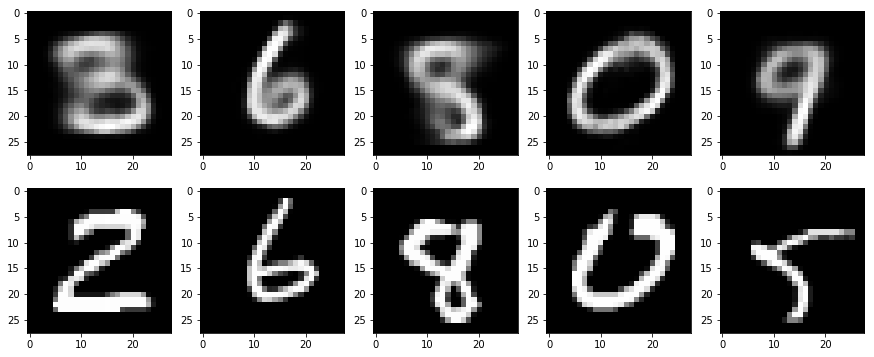

In [62]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()
n = 0
j = 0

for i in range(n,n+5):
    axs[j].imshow(x_tst[i,:].reshape([28,28]),cmap='gray')
    axs[j+5].imshow(test_epoch[i,:].reshape([28,28]),cmap='gray')
    j += 1
    
plt.show()